## Установка

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
CV_FOLDS = 5

BASE_DIR = Path("homeworks/HW06")
if not BASE_DIR.exists():
    BASE_DIR = Path(".")

DATA_PATH = BASE_DIR / "S06-hw-dataset-04.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")

ARTIFACT_DIR = BASE_DIR / "artifacts"
FIG_DIR = ARTIFACT_DIR / "figures"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)


## 1. Загрузка данных и первичный анализ

Датасет: `S06-hw-dataset-04.csv` (бинарная классификация с сильным дисбалансом классов).


In [2]:
df = pd.read_csv(DATA_PATH)
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25000.0,12500.500000,7217.022701,1.000000,6250.750000,12500.500000,18750.250000,25000.000000
f01,25000.0,-0.000386,1.001623,-4.370993,-0.680165,0.001859,0.679702,4.208888
f02,25000.0,-0.004872,0.995606,-4.087073,-0.675100,-0.000247,0.659523,3.984564
f03,25000.0,0.003202,1.004367,-4.103875,-0.675426,0.013272,0.683437,3.793442
f04,25000.0,0.335329,3.207537,-13.249937,-1.750048,0.403483,2.486453,15.288250
...,...,...,...,...,...,...,...,...
f57,25000.0,0.893365,2.445185,-9.508509,-0.735473,0.888535,2.516790,11.880651
f58,25000.0,-0.909479,1.962618,-7.919287,-2.226959,-0.923354,0.395648,6.778980
f59,25000.0,0.000570,0.994320,-4.038312,-0.666367,0.004381,0.666474,3.834922
f60,25000.0,-0.000754,0.997167,-3.812255,-0.665861,0.002420,0.665918,4.012639


In [5]:
df.isna().sum().sort_values(ascending=False).head(10)

id     0
f46    0
f33    0
f34    0
f35    0
f36    0
f37    0
f38    0
f39    0
f40    0
dtype: int64

In [6]:
target_counts = df["target"].value_counts()
target_ratio = df["target"].value_counts(normalize=True)

pd.DataFrame({"count": target_counts, "ratio": target_ratio})

,count,ratio
target,,
0,23770,0.9508
1,1230,0.0492


In [7]:
X = df.drop(columns=["target", "id"])
y = df["target"]

X.shape, y.shape

((25000, 60), (25000,))

## 2. Разделение на обучающую и тестовую выборки

Фиксируем `random_state` для воспроизводимости и используем `stratify=y`, чтобы сохранить
баланс классов в обоих разбиениях - это важно при дисбалансе.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True),
})

,train,test
target,,
0,0.9508,0.9508
1,0.0492,0.0492


## 3. Вспомогательная функция для метрик


In [9]:
is_binary = y.nunique() == 2
f1_average = "binary" if is_binary else "macro"
opt_metric = "roc_auc" if is_binary else "f1_macro"


def evaluate_model(model, X_eval, y_eval, f1_average, is_binary):
    y_pred = model.predict(X_eval)
    metrics = {
        "accuracy": float(accuracy_score(y_eval, y_pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_eval, y_pred)),
        "f1": float(f1_score(y_eval, y_pred, average=f1_average, zero_division=0)),
    }

    if is_binary:
        metrics["precision_pos"] = float(
            precision_score(y_eval, y_pred, pos_label=1, zero_division=0)
        )
        metrics["recall_pos"] = float(
            recall_score(y_eval, y_pred, pos_label=1, zero_division=0)
        )
    else:
        metrics["precision"] = float(
            precision_score(y_eval, y_pred, average=f1_average, zero_division=0)
        )
        metrics["recall"] = float(
            recall_score(y_eval, y_pred, average=f1_average, zero_division=0)
        )

    y_proba = None
    if is_binary:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_eval)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_eval)
        metrics["roc_auc"] = float(roc_auc_score(y_eval, y_proba)) if y_proba is not None else None
        metrics["average_precision"] = (
            float(average_precision_score(y_eval, y_proba)) if y_proba is not None else None
        )
    else:
        metrics["roc_auc"] = None
        metrics["average_precision"] = None

    return metrics, y_pred, y_proba


def to_builtin(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    if isinstance(obj, dict):
        return {k: to_builtin(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_builtin(v) for v in obj]
    return obj


## 4. Базовые модели


In [10]:
models = {}
search_summaries = {}

# Бейзлайн: DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
models["dummy_most_frequent"] = dummy

# Бейзлайн: логистическая регрессия (со стандартизацией)
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])
logreg.fit(X_train, y_train)
models["logreg_scaled"] = logreg

## 5. Модели недели 6 (кросс-валидация только на обучающей)

Подбор гиперпараметров делаем через GridSearchCV только на обучающей выборке.
Метрика оптимизации: `roc_auc` (датасет бинарный и дисбалансный).
Модели: DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier.


In [11]:
# Дерево решений с контролем сложности
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_param_grid = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_leaf": [1, 2, 5, 10],
}

tree_search = GridSearchCV(
    tree,
    tree_param_grid,
    scoring=opt_metric,
    cv=CV_FOLDS,
    n_jobs=-1,
)

tree_search.fit(X_train, y_train)
models["decision_tree"] = tree_search.best_estimator_
search_summaries["decision_tree"] = {
    "best_params": to_builtin(tree_search.best_params_),
    "best_cv_score": float(tree_search.best_score_),
    "scoring": opt_metric,
    "cv": CV_FOLDS,
}

In [12]:
# Случайный лес
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rf_param_grid = {
    "max_depth": [None, 8, 12],
    "max_features": ["sqrt", 0.5],
    "min_samples_leaf": [1, 5],
}

rf_search = GridSearchCV(
    rf,
    rf_param_grid,
    scoring=opt_metric,
    cv=CV_FOLDS,
    n_jobs=-1,
)

rf_search.fit(X_train, y_train)
models["random_forest"] = rf_search.best_estimator_
search_summaries["random_forest"] = {
    "best_params": to_builtin(rf_search.best_params_),
    "best_cv_score": float(rf_search.best_score_),
    "scoring": opt_metric,
    "cv": CV_FOLDS,
}

In [13]:
# Градиентный бустинг
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
}

gb_search = GridSearchCV(
    gb,
    gb_param_grid,
    scoring=opt_metric,
    cv=CV_FOLDS,
    n_jobs=-1,
)

gb_search.fit(X_train, y_train)
models["gradient_boosting"] = gb_search.best_estimator_
search_summaries["gradient_boosting"] = {
    "best_params": to_builtin(gb_search.best_params_),
    "best_cv_score": float(gb_search.best_score_),
    "scoring": opt_metric,
    "cv": CV_FOLDS,
}

## 6. Финальная оценка на тестовой выборке (ровно один раз)

Каждую обученную модель оцениваем один раз на отложенной тестовой выборке и сохраняем результаты.


In [14]:
metrics_test = {}
pred_cache = {}

for name, model in models.items():
    metrics, y_pred, y_proba = evaluate_model(model, X_test, y_test, f1_average, is_binary)
    metrics_test[name] = metrics
    pred_cache[name] = {"y_pred": y_pred, "y_proba": y_proba}

metrics_df = pd.DataFrame(metrics_test).T
sort_col = "average_precision" if "average_precision" in metrics_df.columns else "roc_auc"
if sort_col in metrics_df.columns:
    metrics_df = metrics_df.sort_values(by=sort_col, ascending=False, na_position="last")
metrics_df


,accuracy,balanced_accuracy,f1,precision_pos,recall_pos,roc_auc,average_precision
random_forest,0.9734,0.733529,0.633609,0.982906,0.467480,0.896545,0.751429
gradient_boosting,0.9752,0.767241,0.680412,0.929577,0.536585,0.889408,0.725817
decision_tree,0.9664,0.720212,0.567010,0.774648,0.447154,0.818738,0.517585
logreg_scaled,0.9632,0.639508,0.428571,0.907895,0.280488,0.833987,0.508831
dummy_most_frequent,0.9508,0.500000,0.000000,0.000000,0.000000,0.500000,0.049200


## 7. Выбор модели (критерий кросс-валидации на обучающей)

Лучшую модель выбираем по оценке кросс-валидации на обучающей, а не по метрикам на тесте.


In [15]:
# Лучшая модель по кросс-валидации на обучающей (не по метрикам на тесте)
best_model_name = max(search_summaries, key=lambda k: search_summaries[k]["best_cv_score"])
best_model = models[best_model_name]

best_model_name, search_summaries[best_model_name]

('gradient_boosting',
 {'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
  'best_cv_score': 0.8875544888684253,
  'scoring': 'roc_auc',
  'cv': 5})

## 8. Графики для лучшей модели


<Figure size 640x480 with 0 Axes>

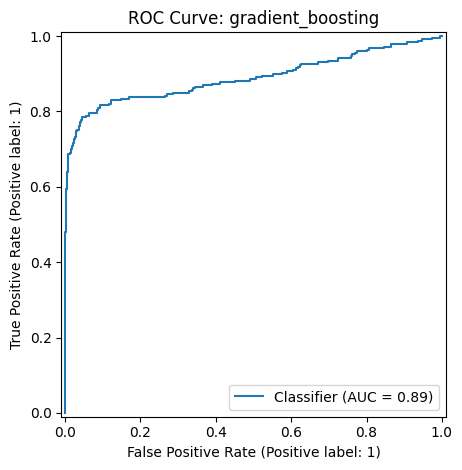

<Figure size 640x480 with 0 Axes>

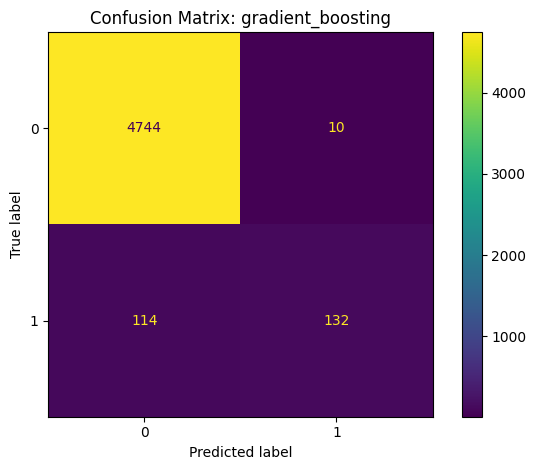

<Figure size 640x480 with 0 Axes>

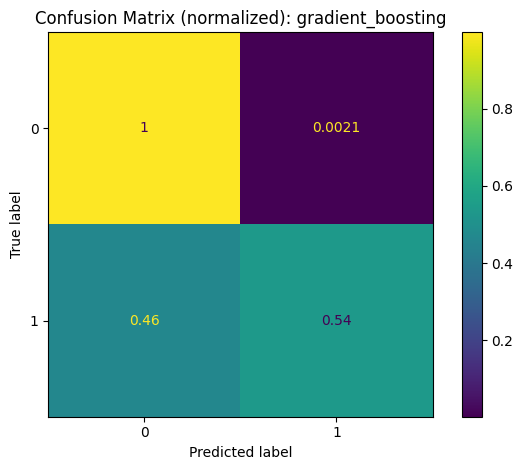

<Figure size 640x480 with 0 Axes>

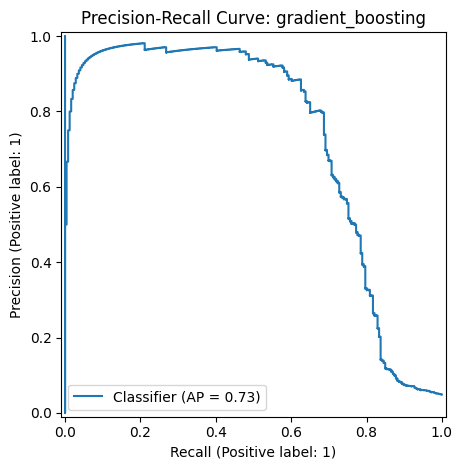

In [16]:
best_pred = pred_cache[best_model_name]

# ROC-кривая (только бинарная задача)
if is_binary and best_pred["y_proba"] is not None:
    plt.figure()
    RocCurveDisplay.from_predictions(y_test, best_pred["y_proba"])
    plt.title(f"ROC Curve: {best_model_name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "roc_curve_best_model.png", dpi=150)
    plt.show()

# Матрица ошибок
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, best_pred["y_pred"])
plt.title(f"Confusion Matrix: {best_model_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix_best_model.png", dpi=150)
plt.show()

# Нормализованная матрица ошибок (по истинным меткам)
plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test,
    best_pred["y_pred"],
    normalize="true",
)
plt.title(f"Confusion Matrix (normalized): {best_model_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix_best_model_normalized.png", dpi=150)
plt.show()


# PR-кривая (полезно при дисбалансе)
if is_binary and best_pred["y_proba"] is not None:
    plt.figure()
    PrecisionRecallDisplay.from_predictions(y_test, best_pred["y_proba"])
    plt.title(f"Precision-Recall Curve: {best_model_name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "pr_curve_best_model.png", dpi=150)
    plt.show()


## 9. Перестановочная важность признаков и интерпретация

Чтобы не трогать тест повторно, перестановочную важность считаем на обучающей.


In [17]:
perm_result = permutation_importance(
    best_model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring=opt_metric,
)

perm_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance_mean": perm_result.importances_mean,
    "importance_std": perm_result.importances_std,
}).sort_values(by="importance_mean", ascending=False)

perm_df.head(15)

,feature,importance_mean,importance_std
53,f54,0.040502,0.002526
24,f25,0.025944,0.001365
57,f58,0.012097,0.001410
12,f13,0.010175,0.001315
40,f41,0.009611,0.000771
10,f11,0.009608,0.002089
52,f53,0.009107,0.001198
32,f33,0.008714,0.001100
46,f47,0.008048,0.001116
37,f38,0.007478,0.000823


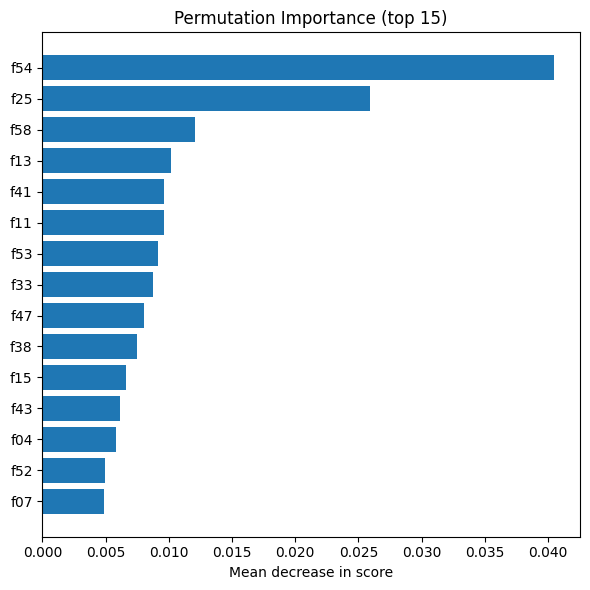

In [18]:
top_n = 15
plot_df = perm_df.head(top_n).sort_values(by="importance_mean")

plt.figure(figsize=(6, 6))
plt.barh(plot_df["feature"], plot_df["importance_mean"])
plt.title(f"Permutation Importance (top {top_n})")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.savefig(FIG_DIR / "permutation_importance_best_model.png", dpi=150)
plt.show()

Интерпретация: наибольший вклад в предсказания дают признаки из топа выше.
Так как признаки синтетические (f01, f02, ...), это относительная важность, а не
"реальный смысл" признака. Разрыв между топом и остальными показывает, на какие входы
модель опирается сильнее.


## 10. Сохранение артефактов эксперимента


In [19]:
# Сохранение метрик и итогов подбора
with open(ARTIFACT_DIR / "metrics_test.json", "w") as f:
    json.dump(to_builtin(metrics_test), f, indent=2)

with open(ARTIFACT_DIR / "search_summaries.json", "w") as f:
    json.dump(to_builtin(search_summaries), f, indent=2)

# Сохранение лучшей модели
joblib.dump(best_model, ARTIFACT_DIR / "best_model.joblib")

best_model_meta = {
    "model_name": best_model_name,
    "selection_metric": opt_metric,
    "best_params": search_summaries[best_model_name]["best_params"],
    "test_metrics": metrics_test[best_model_name],
    "dataset": str(DATA_PATH),
    "random_state": RANDOM_STATE,
    "train_size": int(len(X_train)),
    "test_size": int(len(X_test)),
    "n_features": int(X_train.shape[1]),
}

with open(ARTIFACT_DIR / "best_model_meta.json", "w") as f:
    json.dump(to_builtin(best_model_meta), f, indent=2)

sorted([p.name for p in ARTIFACT_DIR.iterdir()])

['best_model.joblib',
 'best_model_meta.json',
 'figures',
 'metrics_test.json',
 'search_summaries.json']